# Image Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import cv2
import os
from torchvision import transforms
import torch
import pickle
from random import shuffle

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch import optim
%matplotlib inline

In [3]:
import operator
import cv2
import numpy as np
def pre_process_image(img, skip_dilate=False):
    """Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""
    # Gaussian blur with a kernal size (height, width) of 9.
    # Note that kernal sizes must be positive and odd and the kernel must be square.
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)
    # Adaptive threshold using 11 nearest neighbour pixels
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    # Invert colours, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise will look like erosion instead.
    proc = cv2.bitwise_not(proc, proc)
    #if not skip_dilate:
    #    # Dilate the image to increase the size of the grid lines.
    #    kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]])
    #    proc = cv2.dilate(proc, kernel)
    return proc
def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image
    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.
    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]
def display_points(in_img, points, radius=5, colour=(0, 0, 255)):
    """Draws circular points on an image."""
    img = in_img.copy()
    # Dynamically change to a colour image if necessary
    if len(colour) == 3:
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.shape[2] == 1:
            img = find_corners_of_largest_polygon(img)
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image
    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.
    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    for point in points:
        img = cv2.circle(img, tuple(int(x) for x in point), radius, colour, -1)
    show_image(img)
    return img
def show_image(img):
    """Shows an image until any key is pressed."""
    cv2.imshow('image', img)  # Display the image
    cv2.waitKey(0)  # Wait for any key to be pressed (with the image window active)
    cv2.destroyAllWindows()  # Close all windows
def crop_and_warp(img, crop_rect):
	"""Crops and warps a rectangular section from an image into a square of similar size."""
	# Rectangle described by top left, top right, bottom right and bottom left points
	top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]
	# Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
	src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')
	# Get the longest side in the rectangle
	side = max([
		distance_between(bottom_right, top_right),
		distance_between(top_left, bottom_left),
		distance_between(bottom_right, bottom_left),
		distance_between(top_left, top_right)
	])
	# Describe a square with side of the calculated length, this is the new perspective we want to warp to
	dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
	# Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
	m = cv2.getPerspectiveTransform(src, dst)
	# Performs the transformation on the original image
	return cv2.warpPerspective(img, m, (int(side), int(side)))
def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))


In [4]:
img = cv2.imread('img1.jpg', cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(img)
corners = find_corners_of_largest_polygon(processed)
cropped = crop_and_warp(img, corners)
show_image(cropped)

In [5]:
cv2.imwrite( "./cropped1.jpg", cropped)

True

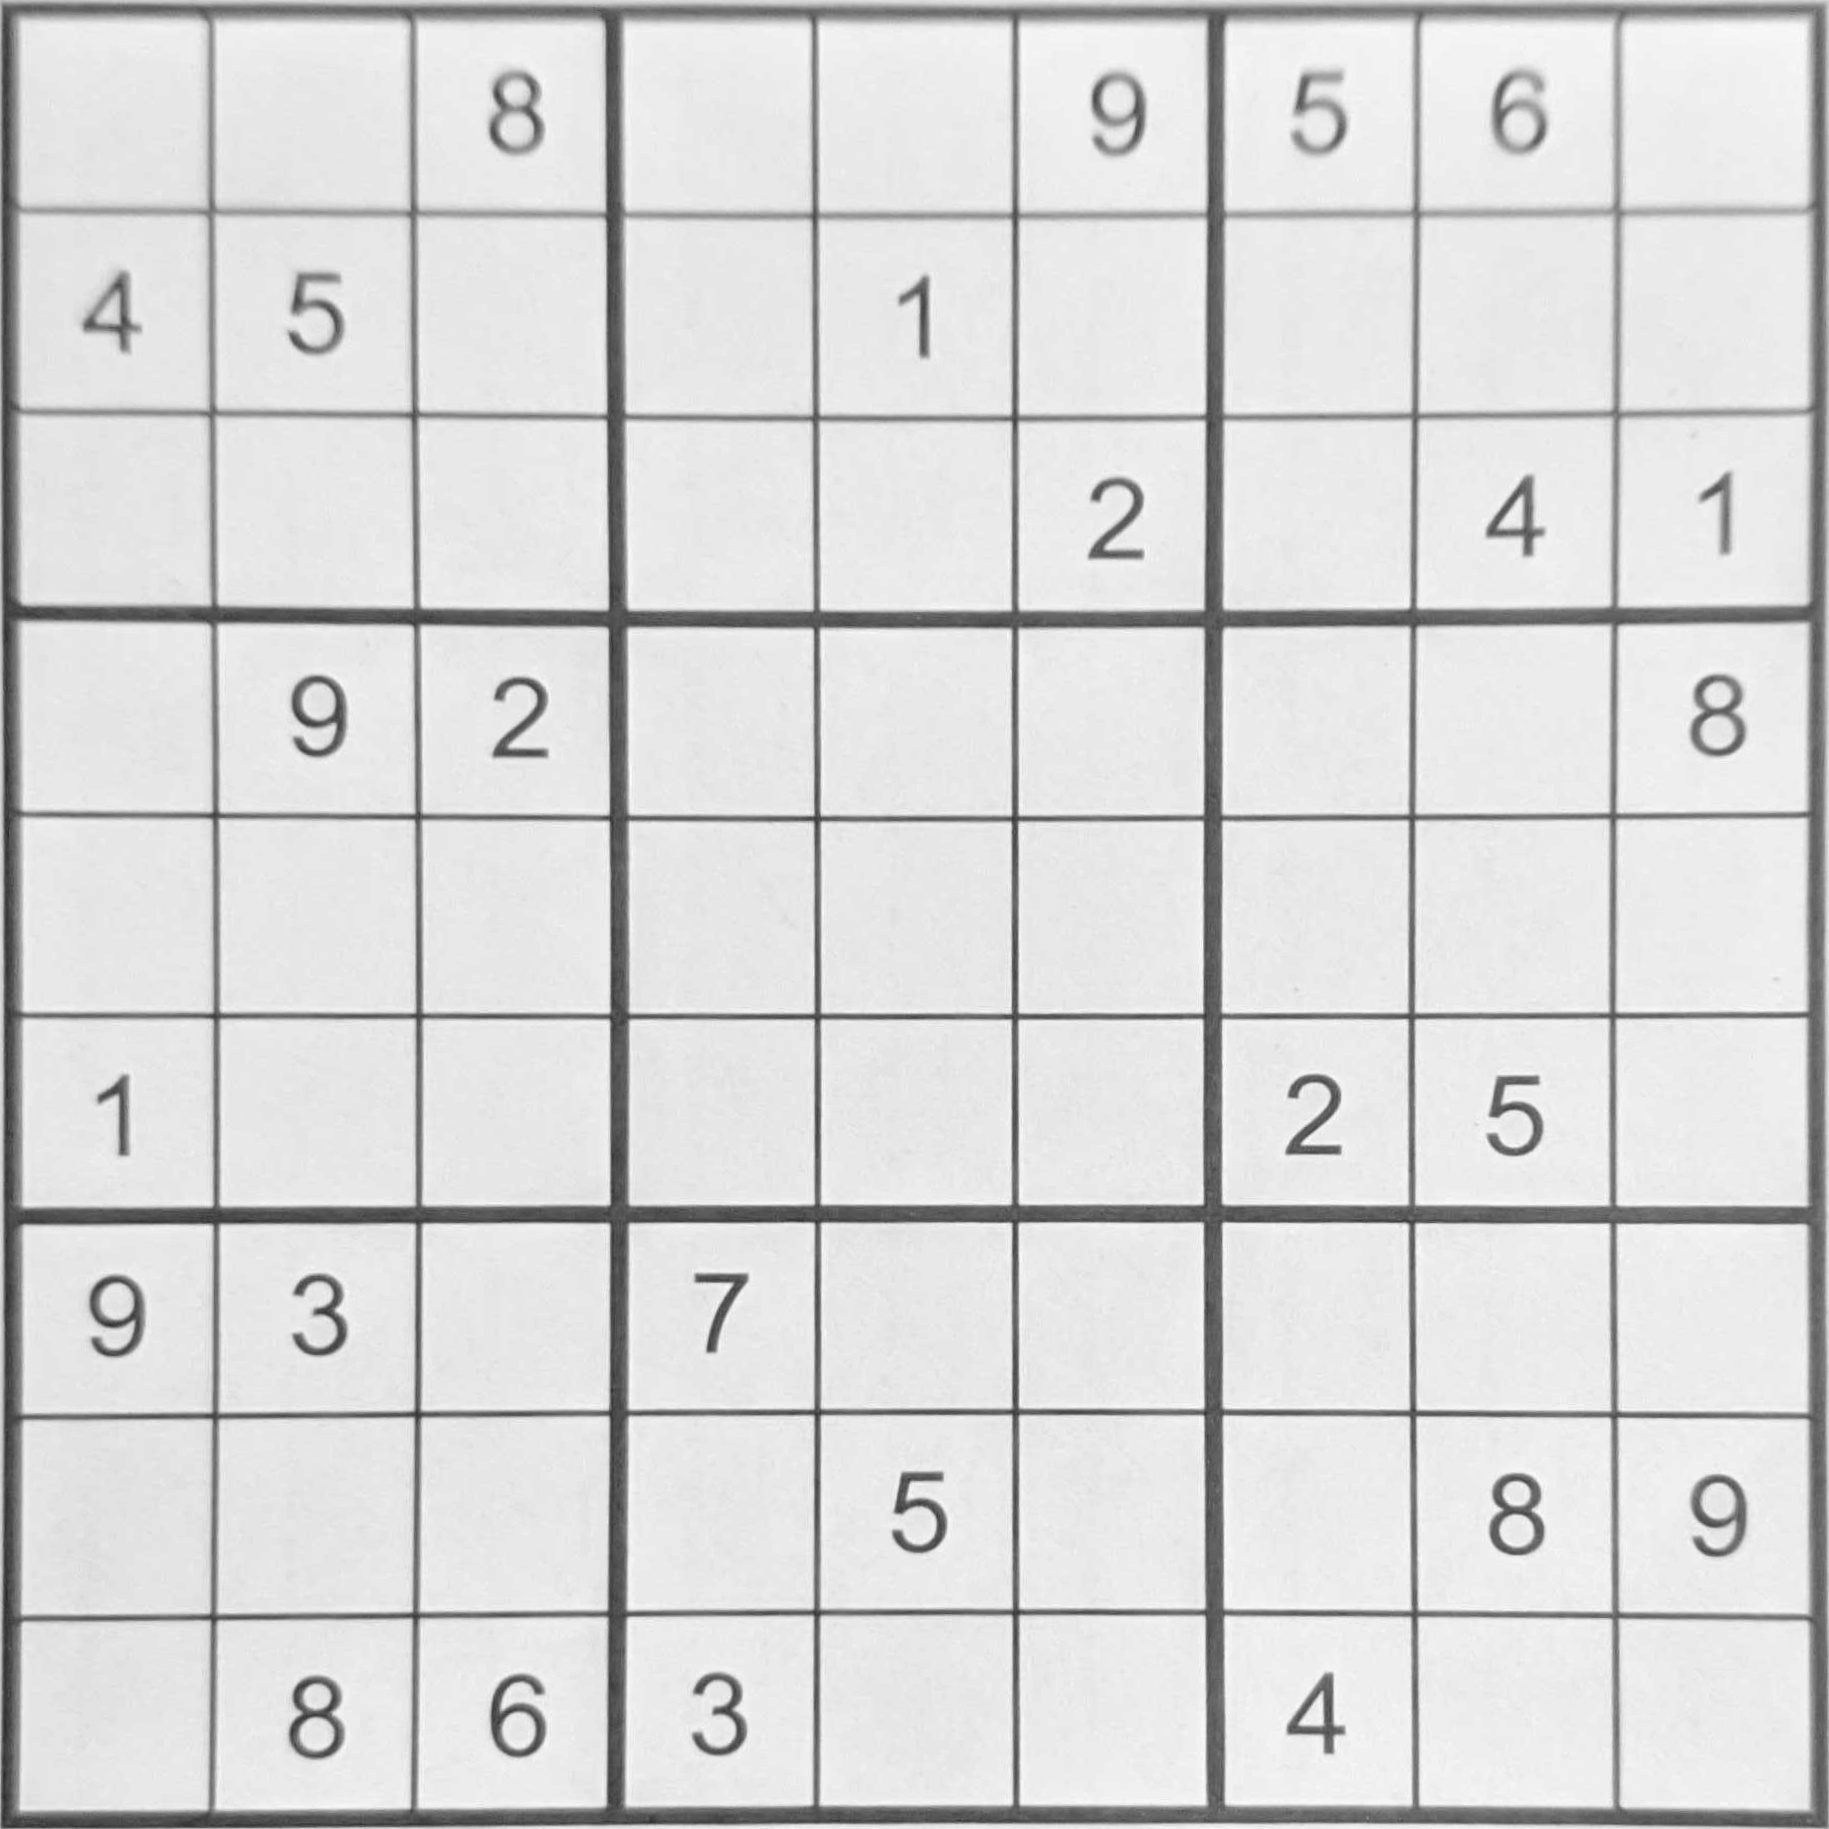

In [6]:
(Image(filename='cropped1.jpg'))

## Read in the image:

In [19]:
filename = 'cropped1.jpg'
img = cv2.imread(filename)

In [20]:
cv2.imshow("Image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

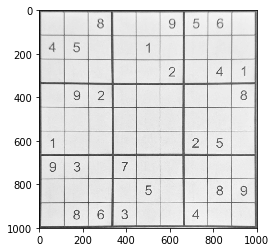

In [21]:
W = 1000
heigh, width, depth = img.shape
imgScale = W/width
newX, newY = img.shape[1]*imgScale, img.shape[0]*imgScale
new_img = cv2.resize(img, (int(newX), int(newY)))
cv2.imshow("Show by CV2", new_img)
cv2.waitKey(0)
cv2.imwrite('resize_white_img.png', new_img)
plt.imshow(new_img) 

In [22]:
invert_img = cv2.bitwise_not(new_img)
cv2.imshow("invert1", invert_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [23]:
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])
# applying the sharpening kernel to the input image & displaying it.
sharpened = cv2.filter2D(invert_img, -1, kernel_sharpening)
cv2.imshow('Image Sharpening', sharpened)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [12]:
# new_img = (cv2.threshold(sharpened, 125, 255, cv2.THRESH_BINARY))
#new_img1 = cv2.threshold(new_img, 200, 255, cv2.THRESH_BINARY)

In [13]:
# invert_img1 = new_img[1]

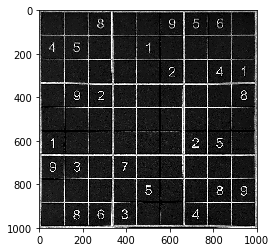

In [24]:
plt.imshow(sharpened)

In [25]:
rows = [(15,125), (125,225), (235,335), (340,440), (455,555), (570,670), (680,780), (775,875), (890,990)]
columns = [(30,130), (130,230), (240,340), (355,455), (455,555), (565,665), (670,770), (800,900),(890,990)]
images_list = []
for unit in rows:
    for units in columns:
        images_list.append(invert_img1[unit[0]:unit[1], units[0]:units[1]])

images_list = []
for unit in rows:
    for units in columns:
        images_list.append(invert_img[unit[0]:unit[1], units[0]:units[1]])

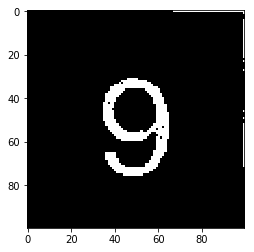

In [35]:
plt.imshow(images_list[71])

### To save the inverted and preprocessed images to local folder:

In [17]:
# for i in range(len(images_list)):
#    if i <= 9:
#        cv2.imwrite("0"+f"{i}_flip.png", images_list[i])
#    else:
#        cv2.imwrite(f"{i}_flip.png", images_list[i])

In [18]:
# for i in range(len(images_list)):
#    cv2.imwrite(f"0{i}_flip.png", images_list[i])

# cv2.imwrite("flip_img81.png", images_list[80])

In [19]:
# To pull in the images from the local folder, and prepare them to be passed onto the model:

In [36]:
final_images = []
for i in range(len(images_list)):
#    img_array = cv2.imread(os.path.join(IMG_DIR, images))
    img_array = cv2.cvtColor(images_list[i], cv2.COLOR_BGR2GRAY)
    resize_img = cv2.resize(img_array, (28,28))
    final_images.append(resize_img)

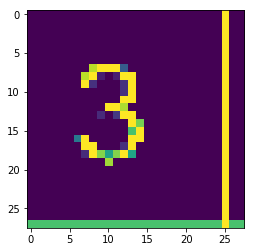

In [39]:
plt.imshow(final_images[75]) # 47, 57, 69, 

In [77]:
final_images[78].mean()

70.41581632653062

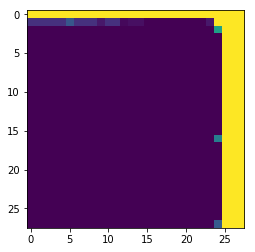

In [26]:
plt.imshow(final_images[20])

In [39]:
img_change = cv2.threshold(final_images[78], 130, 255, cv2.THRESH_BINARY)
#plt.imshow(img_change)

## How to save?

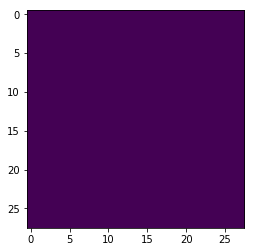

In [15]:
plt.imshow(np.full_like(final_images[5], 0))

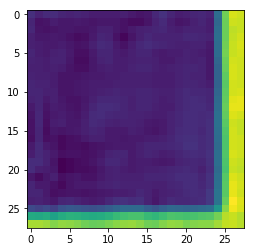

In [16]:
plt.imshow(final_images[59])

# Creating tuples

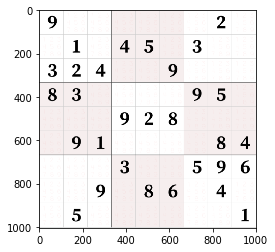

In [497]:
plt.imshow(new_img)

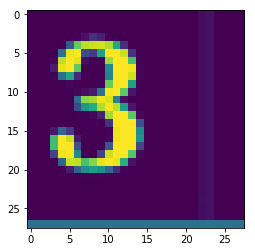

In [513]:
plt.imshow(final_images[18])

In [502]:
copy_img71_1=[(np.copy(final_images[10]),1)for i in range(20)] # values is the image
copy_img71_2 = [(np.copy([final_images[47]]),1)for i in range(20)]
copy_img71_3 = [(np.copy([final_images[80]]), 1) for i in range(20)]
#opy_img61_4= [(np.copy([final_images[48]]), 1) for i in range(20)]
#opy_img61_5 = [(np.copy([final_images[68]]), 1) for i in range(20)]

In [503]:
copy_img71_1.extend(copy_img71_2)
copy_img71_1.extend(copy_img71_3)
# copy_img51_1.extend(copy_img51_4)
# copy_img51_1.extend(copy_img51_5)
len(copy_img71_1)

60

In [507]:
copy_img72_1 = [(np.copy([final_images[7]]), 2) for i in range(20)]
copy_img72_2 = [(np.copy([final_images[19]]), 2) for i in range(20)]
copy_img72_3 = [(np.copy([final_images[40]]), 2) for i in range(20)]
# copy_img52_4 = [(np.copy([final_images[63]]), 2) for i in range(20)]
# copy_img2_5 = [(np.copy(final_images[66]), 2) for i in range(20)]
# copy_img2_6 = [(np.copy(final_images[66]), 2) for i in range(20)]

In [508]:
copy_img72_1.extend(copy_img72_2)
copy_img72_1.extend(copy_img72_3)
# copy_img52_1.extend(copy_img52_4)
len(copy_img72_1)

60

In [514]:
copy_img73_1 = [(np.copy([final_images[15]]), 3) for i in range(20)]
copy_img73_2 = [(np.copy([final_images[18]]), 3) for i in range(20)]
copy_img73_3 = [(np.copy([final_images[28]]), 3) for i in range(20)]
copy_img73_4 = [(np.copy([final_images[57]]), 3) for i in range(20)]
# copy_img33_5 = [(np.copy([final_images[75]]), 3) for i in range(20)]
#copy_img3_6 = [(np.copy(final_images[66]), 3) for i in range(20)]

In [515]:
copy_img73_1.extend(copy_img73_2)
copy_img73_1.extend(copy_img73_3)
copy_img73_1.extend(copy_img73_4)
# copy_img33_1.extend(copy_img33_5)
len(copy_img73_1)

80

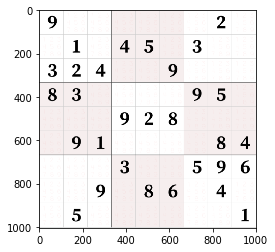

In [516]:
plt.imshow(new_img)

In [521]:
copy_img74_1 = [(np.copy([final_images[12]]), 4) for i in range(20)]
copy_img74_2 = [(np.copy([final_images[20]]), 4) for i in range(20)]
copy_img74_3 = [(np.copy([final_images[53]]), 4) for i in range(20)]
copy_img74_4 = [(np.copy([final_images[70]]), 4) for i in range(20)]
#copy_img4_5 = [(np.copy(final_images[60]), 4) for i in range(20)]
#copy_img4_6 = [(np.copy(final_images[66]), 4) for i in range(20)]

In [522]:
copy_img74_1.extend(copy_img74_2)
copy_img74_1.extend(copy_img74_3)
copy_img74_1.extend(copy_img74_4)
len(copy_img74_1)

80

In [523]:
copy_img75_1 = [(np.copy([final_images[13]]), 5) for i in range(20)]
copy_img75_2 = [(np.copy([final_images[34]]), 5) for i in range(20)]
copy_img75_3 = [(np.copy([final_images[60]]), 5) for i in range(20)]
copy_img75_4 = [(np.copy([final_images[73]]), 5) for i in range(20)]
# copy_img55_5 = [(np.copy([final_images[76]]), 5) for i in range(20)]
# copy_img25_6 = [(np.copy(final_images[66]), 5) for i in range(20)]

In [524]:
copy_img75_1.extend(copy_img75_2)
copy_img75_1.extend(copy_img75_3)
copy_img75_1.extend(copy_img75_4)
# copy_img55_1.extend(copy_img55_5)
len(copy_img75_1)

80

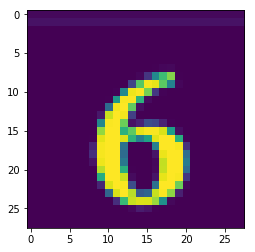

In [529]:
plt.imshow(final_images[68])

In [531]:
copy_img76_1 = [(np.copy([final_images[62]]), 6) for i in range(20)]
copy_img76_2 = [(np.copy([final_images[68]]), 6) for i in range(20)]
# copy_img66_3 = [(np.copy([final_images[54]]), 6) for i in range(20)]
#copy_img26_4 = [(np.copy([final_images[]]), 6) for i in range(20)]
#copy_img6_5 = [(np.copy(final_images[57]), 6) for i in range(20)]
#copy_img6_6 = [(np.copy(final_images[6]), 6) for i in range(20)]

In [532]:
copy_img76_1.extend(copy_img76_2)
# copy_img56_1.extend(copy_img56_3)
# copy_img36_1.extend(copy_img36_4)
len(copy_img76_1)
# copy_img26_1.extend(copy_img26_4)

40

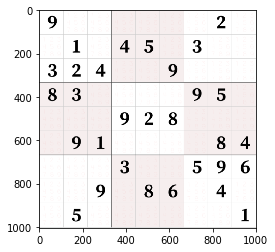

In [533]:
plt.imshow(new_img)

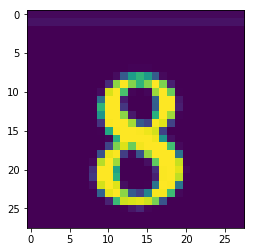

In [539]:
plt.imshow(final_images[67])

In [456]:
copy_img67_1 = [(np.copy([final_images[13]]), 7) for i in range(20)]
copy_img67_2 = [(np.copy([final_images[50]]), 7) for i in range(20)]
# copy_img57_3 = [(np.copy([final_images[]]), 7) for i in range(20)]
# copy_img57_4 = [(np.copy([final_images[57]]), 7) for i in range(20)]
# copy_img57_5 = [(np.copy([final_images[71]]), 7) for i in range(20)]
#copy_img27_6 = [(np.copy([final_images[57]]), 7) for i in range(20)]
#copy_img27_7 = [(np.copy([final_images[69]]), 7) for i in range(20)]

In [457]:
copy_img67_1.extend(copy_img67_2)
# copy_img57_1.extend(copy_img57_3)
# copy_img57_1.extend(copy_img57_4)
# copy_img57_1.extend(copy_img57_5)
#copy_img57_1.extend(copy_img27_6)
#copy_img27_1.extend(copy_img27_7)
len(copy_img67_1)

40

In [540]:
copy_img78_1 = [(np.copy([final_images[27]]), 8) for i in range(20)]
copy_img78_2 = [(np.copy([final_images[41]]), 8) for i in range(20)]
copy_img78_3 = [(np.copy([final_images[52]]), 8) for i in range(20)]
copy_img78_4 = [(np.copy([final_images[67]]), 8) for i in range(20)]
# copy_img18_5 = [(np.copy([final_images[54]]), 8) for i in range(20)]
# copy_img8_6 = [(np.copy(final_images[66]), 8) for i in range(20)]

In [541]:
copy_img78_1.extend(copy_img78_2)
copy_img78_1.extend(copy_img78_3)
copy_img78_1.extend(copy_img78_4)
# copy_img28_1.extend(copy_img28_5)
len(copy_img78_1)

80

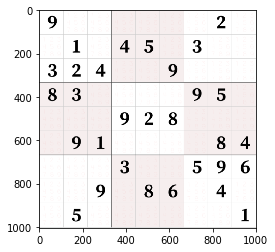

In [542]:
plt.imshow(new_img)

In [42]:
# copy_img1_1[0][0].shape

In [548]:
copy_img79_1 = [(np.copy([final_images[0]]), 9) for i in range(22)]
copy_img79_2 = [(np.copy([final_images[23]]), 9) for i in range(22)]
copy_img79_3 = [(np.copy([final_images[39]]), 9) for i in range(22)]
copy_img79_4 = [(np.copy([final_images[46]]), 9) for i in range(22)]
copy_img79_5 = [(np.copy([final_images[61]]), 9) for i in range(22)]
copy_img79_6 = [(np.copy([final_images[65]]), 9) for i in range(20)]
copy_img79_7 = [(np.copy([final_images[33]]), 9) for i in range(20)]

In [549]:
copy_img79_1.extend(copy_img79_2)
copy_img79_1.extend(copy_img79_3)
copy_img79_1.extend(copy_img79_4)
copy_img79_1.extend(copy_img79_5)
copy_img79_1.extend(copy_img79_6)
copy_img79_1.extend(copy_img79_7)
len(copy_img79_1)

150

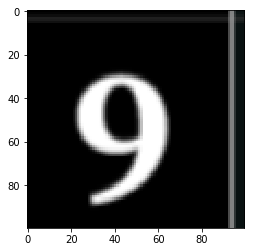

In [553]:
plt.imshow(images_list[65])

In [556]:
#copy_img71_1.extend(copy_img72_1)
#copy_img71_1.extend(copy_img73_1)
#copy_img71_1.extend(copy_img74_1)
#copy_img71_1.extend(copy_img75_1)
#copy_img71_1.extend(copy_img76_1)
#copy_img71_1.extend(copy_img77_1)
copy_img71_1.extend(copy_img78_1)
copy_img71_1.extend(copy_img79_1)

In [557]:
len(copy_img71_1)

630

In [558]:
shuffle(copy_img71_1)

In [71]:
first_list = copy_img11_1

In [156]:
len(first_list)

650

In [155]:
second_list = copy_img21_1
len(second_list)

620

In [240]:
third_list = copy_img31_1
len(third_list)

610

In [315]:
fourth_list = copy_img41_1
len(fourth_list)

588

In [403]:
fifth_list = copy_img51_1
len(fifth_list)

628

In [478]:
sixth_list = copy_img61_1
len(sixth_list)

468

In [559]:
seventh_list = copy_img71_1
len(seventh_list)

630

In [464]:
# plt.imshow(second_list[0][0])

In [560]:
first_list.extend(second_list)
first_list.extend(third_list)
first_list.extend(fourth_list)
first_list.extend(fifth_list)
first_list.extend(sixth_list)
first_list.extend(seventh_list)
len(first_list)

4194

In [561]:
shuffle(first_list)

In [138]:
#first_list = copy_img1_1
print(len(first_list))
len(second_list)
#type(first_list)

620


610

In [426]:
# helper.imshow(first_list[0][0])
first_list[0][1]

2

# Pickle the files

In [562]:
import pickle
with open('final_list', 'wb') as f:
    pickle.dump(first_list, f)

### Transform numpy arrays to tensors

In [563]:
transform = transforms.ToTensor()

In [565]:
tensors = []
for num in first_list:
    tensors.append((transform(num[0]).view(1,28,28).type(torch.FloatTensor), num[1]))
        
#    for i, b in num: #num represents the tuple itself
#        i = transform(i)
#        tensors.append((i,b))
#        transform(copy_img1_1[i][b])

In [566]:
type(tensors)

list

In [568]:
type(tensors[200])

tuple

In [569]:
(tensors[203][0]).dtype

torch.float32

In [570]:
len(tensors)

4194

In [571]:
tensors[20][0].shape # 1 is the number of images, 1 is the layers i.e. RGB vs Gray and 28*28 is the size

torch.Size([1, 28, 28])

In [572]:
# train_loader = (n for n in tensors)
# batch = next(iter(train_loader))
# images, labels = batch
# images, labels = batch


In [573]:
train_loader = torch.utils.data.DataLoader(tensors, batch_size=10, shuffle=True)

In [574]:
batch = next(iter(train_loader))
print('len:', len(batch))

len: 2


In [575]:
images, labels = batch

In [576]:
print('Types:', type(images), type(labels))
print('shapes:', images.shape, labels.shape)


Types: <class 'torch.Tensor'> <class 'torch.Tensor'>
shapes: torch.Size([10, 1, 28, 28]) torch.Size([10])


In [577]:
labels

tensor([6, 9, 9, 9, 2, 9, 1, 3, 8, 6])

In [578]:
import torchvision

labels: tensor([6, 9, 9, 9, 2, 9, 1, 3, 8, 6])


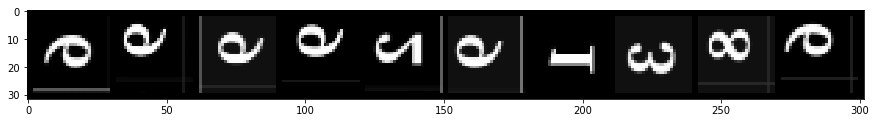

In [579]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
# plt.imshow(grid)
plt.imshow(np.transpose(grid, (1,2,0)))

print('labels:', labels)

In [580]:
import helper

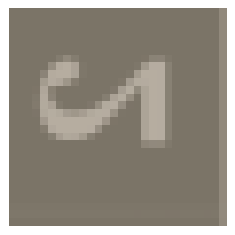

In [582]:
# images, label = next(iter(train_loader))
helper.imshow(images[4,:]);

# Models

We will be creating a CNN to train our model.

In [ ]:
# Build our own network.

In [595]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [596]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [597]:
train_loader = torch.utils.data.DataLoader(tensors, batch_size=10, shuffle=True)

In [598]:
batch = next(iter(train_loader))
print('len:', len(batch))

len: 2


In [599]:
images, labels = batch

In [600]:
print('Types:', type(images), type(labels))
print('shapes:', images.shape, labels.shape)


Types: <class 'torch.Tensor'> <class 'torch.Tensor'>
shapes: torch.Size([10, 1, 28, 28]) torch.Size([10])


In [601]:
labels

tensor([7, 3, 8, 4, 4, 3, 7, 5, 2, 3])

In [602]:
preds = model(images) # Pass Batch
loss = F.cross_entropy(preds, labels) # Calculate Loss

loss.backward() # Calculate Gradients
optimizer.step() # Update Weights

print('loss1:', loss.item())
preds = model(images)
loss = F.cross_entropy(preds, labels)
print('loss2:', loss.item())

loss1: 2.296177387237549
loss2: 2.296177387237549


In [610]:
network = ConvolutionalNetwork()
optimizer = optim.Adam(network.parameters(), lr=0.01)
train_loader = torch.utils.data.DataLoader(
    tensors
    ,batch_size=100
    ,shuffle=True
)

In [611]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [612]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [613]:
for epoch in range(50):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: 1825 loss: 64.77905669808388
epoch 1 total_correct: 3874 loss: 10.74379164725542
epoch 2 total_correct: 4084 loss: 3.2741412948817015
epoch 3 total_correct: 4068 loss: 2.966081006452441
epoch 4 total_correct: 4096 loss: 2.768277336843312
epoch 5 total_correct: 4094 loss: 2.123554895631969
epoch 6 total_correct: 4087 loss: 2.059923170134425
epoch 7 total_correct: 4098 loss: 2.055392000824213
epoch 8 total_correct: 4083 loss: 1.9895523474551737
epoch 9 total_correct: 4088 loss: 1.7935867002233863
epoch 10 total_correct: 4083 loss: 1.7633537399815395
epoch 11 total_correct: 4085 loss: 1.6185601195320487
epoch 12 total_correct: 4087 loss: 1.5787895508110523
epoch 13 total_correct: 4097 loss: 1.5741482926532626
epoch 14 total_correct: 4088 loss: 1.733975600451231
epoch 15 total_correct: 4086 loss: 1.6885339971631765
epoch 16 total_correct: 4087 loss: 1.68735371530056
epoch 17 total_correct: 4083 loss: 1.5554648032411933
epoch 18 total_correct: 4091 loss: 1.51925655786

In [578]:
images.shape

(28, 28, 3)

In [614]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [615]:
checkpoint = {'model': model,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint1.pth')

In [609]:
torch.save(model, 'model1.pth')

In [617]:
torch.save(model.state_dict(), 'model1.pth')

In [ ]:
#the_model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load('model1.pth'))

# Making Predictions

In [640]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [642]:
transform = transforms.ToTensor()

In [643]:
tensor_images = []
for images in final_images:
    tensors = torch.tensor(images, dtype=torch.float)
    tensor_images.append(tensors)

In [647]:
model(tensor_images[79].view(1,1,28,28)).argmax()

tensor(3)

In [651]:
IMG_DIR = 'C:/Users/Billi/repos/sudoku/images/Square5'

In [652]:
filenames = os.listdir(IMG_DIR)
#filenames.sort()
final_images1 = []
for images in filenames:
    img_array = cv2.imread(os.path.join(IMG_DIR, images))
#    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
#    resize_img = cv2.resize(img_array, (28,28))
    final_images1.append(img_array)

In [656]:
#pred_tensor = []
#for num in final_images1:
#pred_tensor.append((transform(num[0]).view(1,28,28).type(torch.FloatTensor), num[1]))

In [654]:
for i in range(len(final_images1)):
    if final_images1[i].max() != 255:
        np.full_like(final_images1[i], 0)

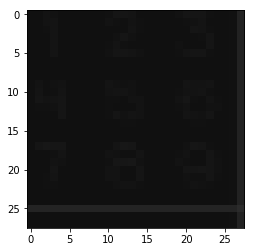

In [655]:
plt.imshow(final_images1[4])

In [566]:
final_images1[4].mean()

18.038265306122447

In [580]:
transform = transforms.ToTensor()
tensor_images1 = []
for images in final_images1:
    tensors1 = torch.tensor(images, dtype=torch.float)
    tensor_images1.append(tensors1)

In [583]:
tensor_images1[5].shape

torch.Size([28, 28, 3])

In [584]:
def convert(tensor): # always be passing in an array
    grid = []
    for i in range(len(tensor_images1)):
        if tensor[i].mean().item() <= 22:
            grid.append(".")
        else:
            grid.append(str(network(tensor[i]).argmax().item()))
    return grid

In [585]:
convert(tensor_images1)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 6 1 3, but got 3-dimensional input of size [28, 28, 3] instead

In [539]:
len(tensors)

8564

In [524]:
optimizer = optim.Adam(network.parameters(), lr=0.01)

total_loss = 0
total_correct = 0

for batch in next(iter(train_loader)): # Get Batch
    images, labels = batch 

    preds = network(images) # Pass Batch
    loss = F.cross_entropy(preds, labels) # Calculate Loss

    optimizer.zero_grad()
    loss.backward() # Calculate Gradients
    optimizer.step() # Update Weights

    total_loss += loss.item()
#    total_correct += get_num_correct(preds, labels)
    
print(
    "epoch:", 0, 
#    "total_correct:", total_correct, 
    "loss:", total_loss
)

ValueError: too many values to unpack (expected 2)

In [519]:

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 25
for e in range(epochs):
    running_loss = 0
    for images, labels in next(iter(train_loader)):
        # Flatten MNIST images into a 784 long vector
        images = images.view(1,28,28).argmax()
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(train_loader)}")

ValueError: too many values to unpack (expected 2)

In [567]:
def convert(tensor): # always be passing in an array
    grid = []
    for i in range(len(tensor)):
        if tensor[i].mean().item() <= 22:
            grid.append(".")
        else:
            grid.append(str(model(tensor[i].view(1,1,28,28)).argmax().item()))
    return grid

In [591]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [592]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [593]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [594]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
#        if b%600 == 0:
#            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
#accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

In [ ]:

for i in range(len(final_images)):
    if final_images[i].max() != 255:
        np.full_like(final_images[i], 0)